# AcousticBrainz Genre Task 2017: Content-based music genre recognition from multiple sources

In [1]:
# Nice graphs for high dpi screens
%config InlineBackend.figure_format = 'retina'

## Install and import packages

In [2]:
!pip install -U scikit-learn[alldeps]
!pip install -U python-dotenv
!pip install -U pandas


Requirement already up-to-date: scikit-learn[alldeps] in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.6.1; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: scipy>=0.9; extra == "alldeps" in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from scikit-learn[alldeps])
Requirement already up-to-date: python-dotenv in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: click>=5.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages (from python-dotenv)
Requirement already up-to-date: pandas in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages
Requirement already up-to-date: numpy>=1.7.0 in /Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages

In [3]:
from os import environ
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

settings = {
    "path": environ.get("PATH_TO_DATASET"),
    "loaded_data": environ.get('LOADED_TRAINING_DATA'),
    
    "very_few": environ.get('VERY_FEW_RECORDS', False),  # Limit the dataset to very few records, useful during development
}

You **must** restart the kernel after first instaling or updating packages!

In [17]:
from sklearn import svm
import pandas as pd
import json


In [5]:
# Read tsv file into groundtruth and extract only id and main genre from it
groundtruth_raw = pd.read_table(settings['path'] + 'groundtruth/acousticbrainz-mediaeval2017-tagtraum-train.tsv')
groundtruth_raw = groundtruth_raw[['recordingmbid', 'genre1']]

def isInLoadedDataset(id):
    return id[0] in settings['loaded_data']
    
groundtruth_available = groundtruth_raw.apply(lambda x: isInLoadedDataset(x['recordingmbid']), axis=1)
groundtruth = groundtruth_raw[groundtruth_available]
print 'Groundtruth raw: %d' % len(groundtruth_raw)
print 'Groundtruth only available: %d' % len(groundtruth)


print 'Found {} unique genres.'.format(len(groundtruth['genre1'].unique()))


Groundtruth raw: 486740
Groundtruth only available: 30599
Found 31 unique genres.


In [6]:

if settings['very_few']:
    groundtruth = groundtruth.head(10000)


## Data Understanding

In [31]:
from collections import Counter
genre = Counter(groundtruth.genre1).keys() # equals to list(set(words))
counter = Counter(groundtruth.genre1).values() # counts the elements' frequency

# genre_list = []
# for i in genre:
#     genre_list[i] = [genre[i], counter[i]]
df = pd.DataFrame(genre)
df_2 = pd.DataFrame(counter)
df_new = pd.concat([df, df_2], axis=1)
df_new

,0,0
0,industrial,256
1,childrens,41
2,classical,516
3,dance,1520
4,reggaeton,1
5,dubstep,128
6,blues,777
7,electronic,2106
8,folk,739
9,trance,137


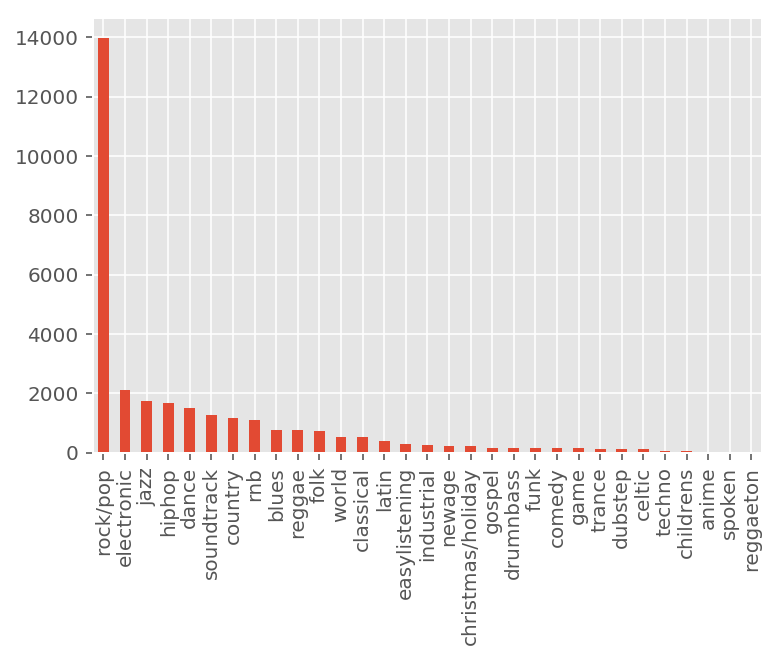

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

groundtruth.genre1.value_counts().plot(kind='bar')
plt.show()
 #show power distribution

## Utility functions

In [135]:
import types

def loadFeatures(recordingmbid):
    feature_file_path = '{basepath}acousticbrainz-mediaeval-train/{id_prefix}/{id}.json'.format(
        basepath = settings['path'], id_prefix=recordingmbid[0:2], id = recordingmbid);
    
    with open(feature_file_path) as feature_file:    
        data = json.load(feature_file)
    
    return data

def pettyPrintJSON(object_to_print):
    print(json.dumps(object_to_print, sort_keys=True, indent=4))
    

def getOnlyUsedFeatures(recordingmbid):
    
    all_features = loadFeatures(recordingmbid)
    
    used_features = [
        #'lowlevel.mfcc.mean',
        'lowlevel.average_loudness']
        #'lowlevel.spectral_energy.mean']
    
    result_features = []
    
    for feature_name in used_features:
        reduced_features = all_features

        for k in feature_name.split('.'):
            reduced_features = reduced_features[k]
            
        #reduced_features = [reduced_features]
        result_features.append(reduced_features)
        
    return pd.Series(result_features)
    

training_data = groundtruth['recordingmbid'].apply(getOnlyUsedFeatures)

print training_data.head()

            0
53   0.855276
75   0.865318
76   0.904938
79   0.877631
101  0.432806


### See distribution of average loudness of each genre music

In [151]:
myset = set(groundtruth['genre1'])

industrial
(10,)


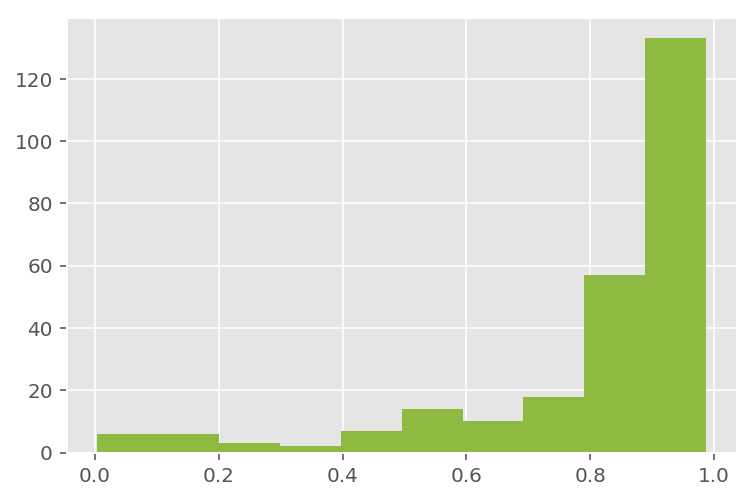

childrens
(10,)


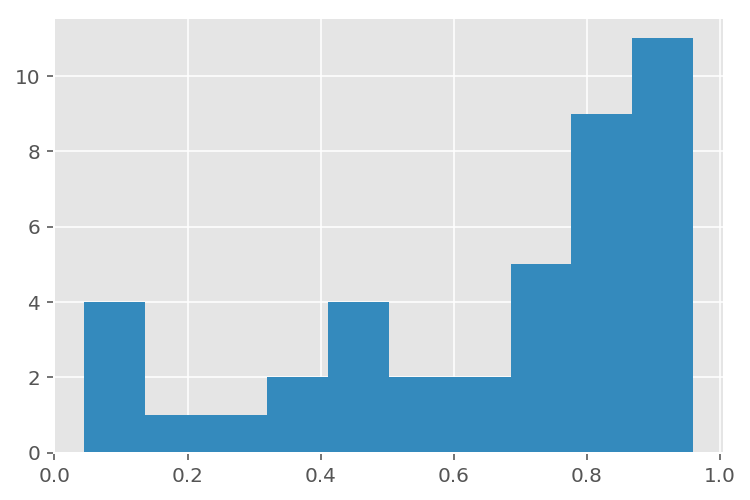

classical
(10,)


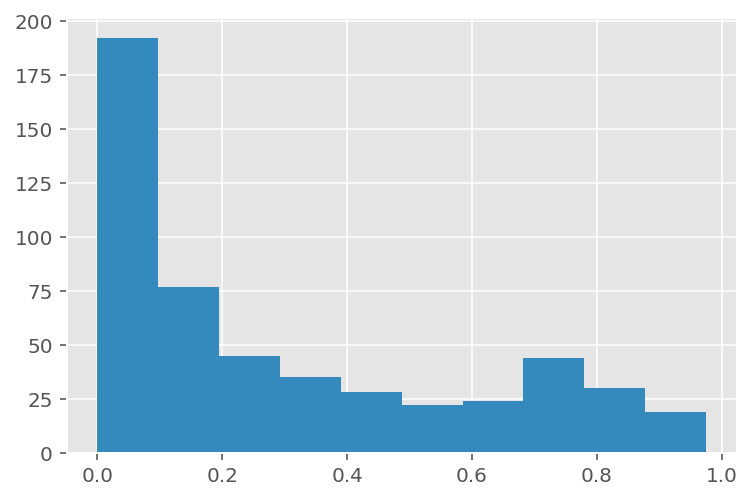

dance
(10,)


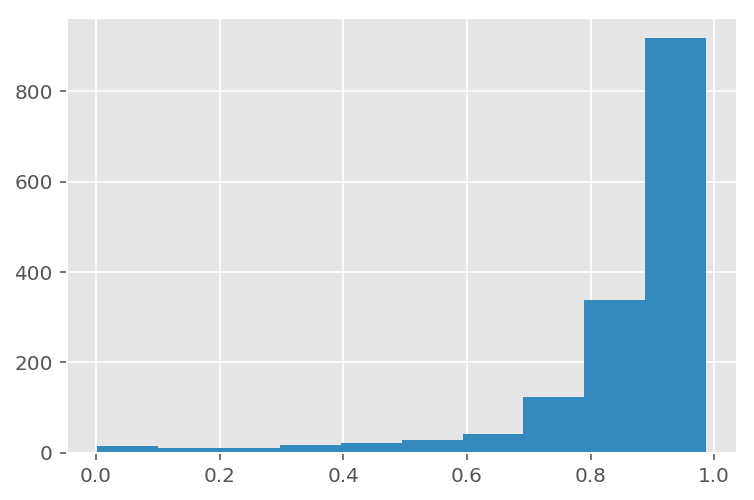

reggaeton
(10,)


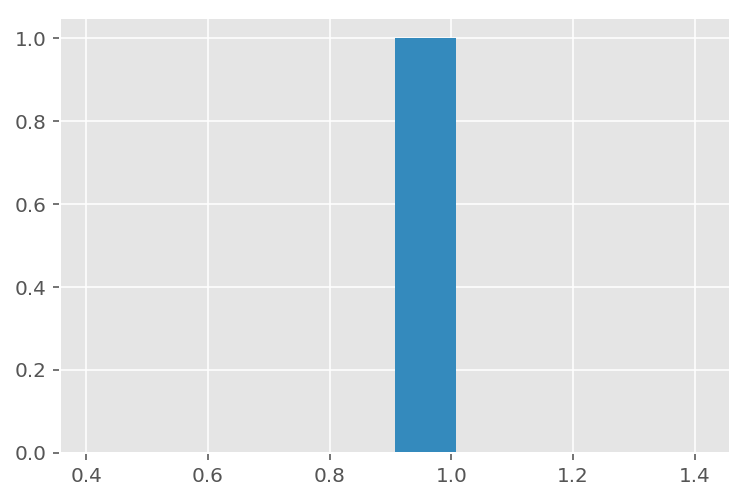

dubstep
(10,)


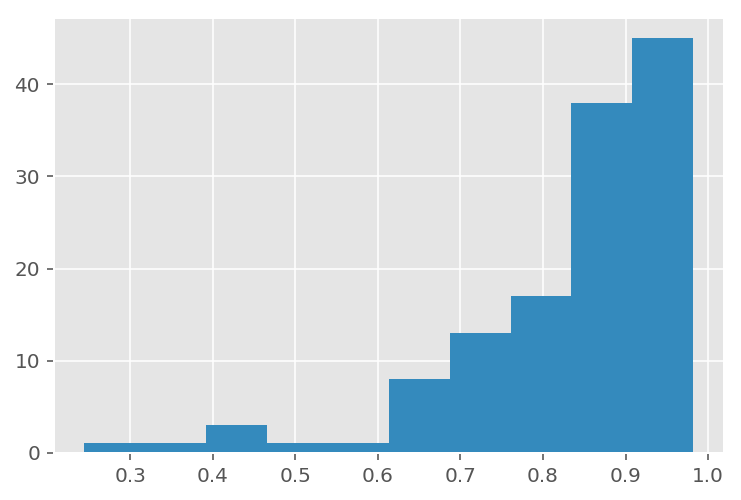

blues
(10,)


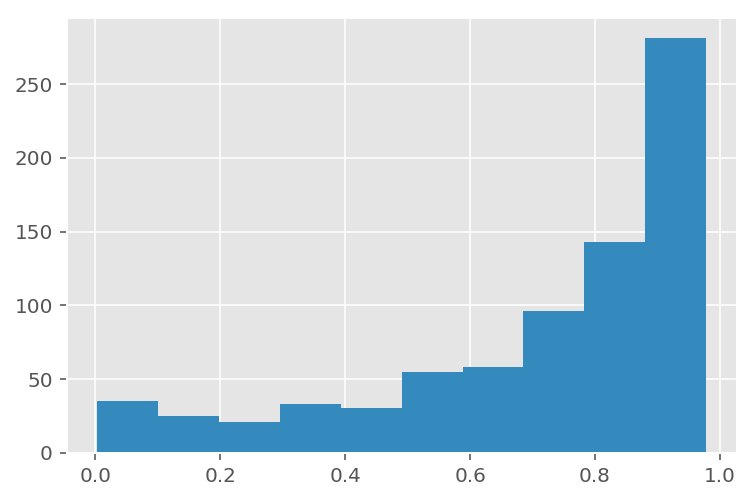

electronic
(10,)


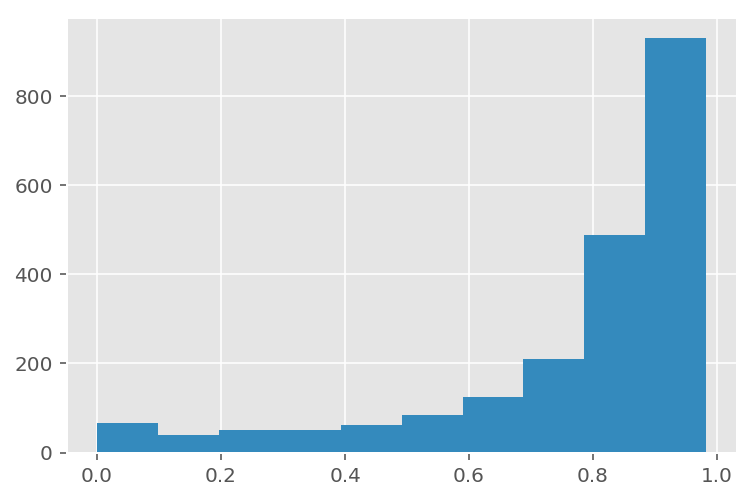

folk
(10,)


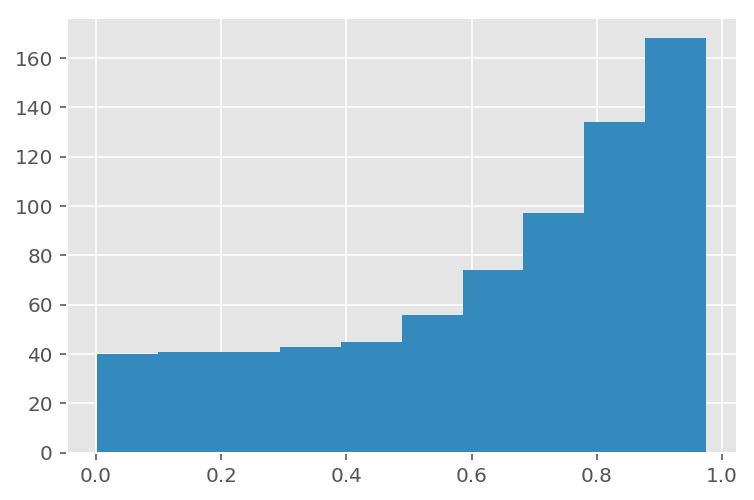

trance
(10,)


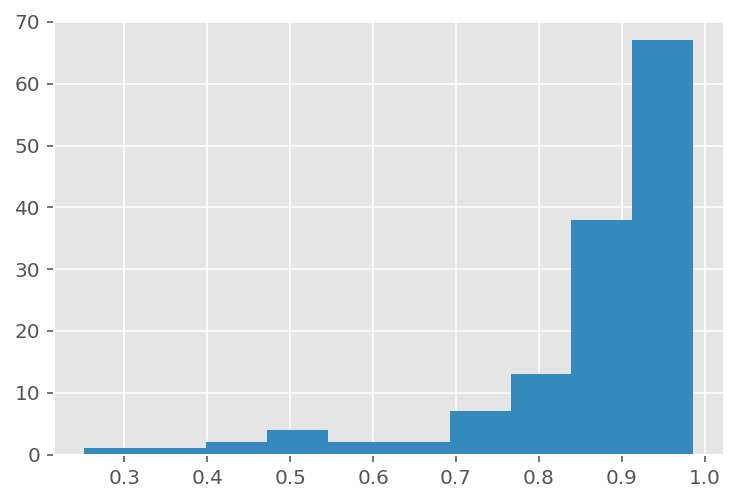

spoken
(10,)


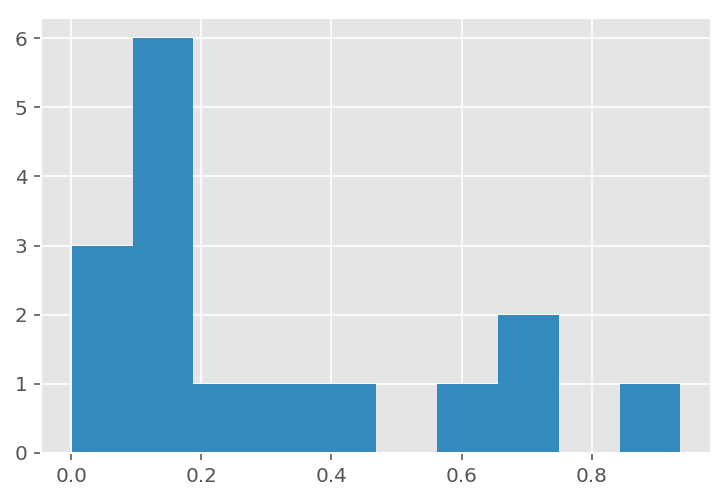

comedy
(10,)


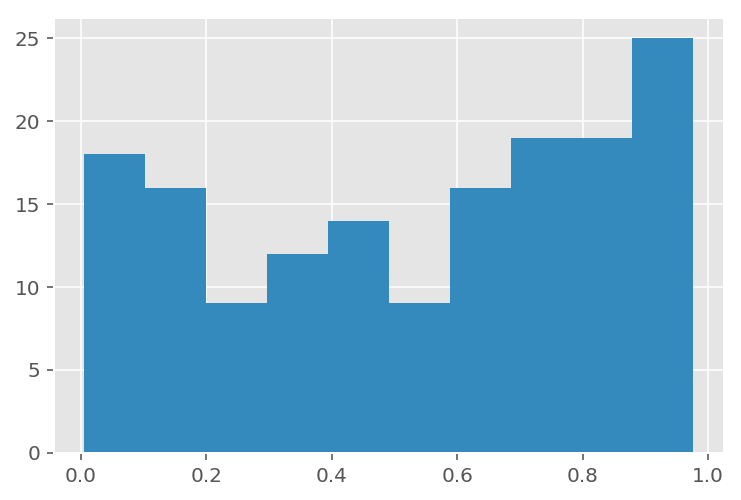

newage
(10,)


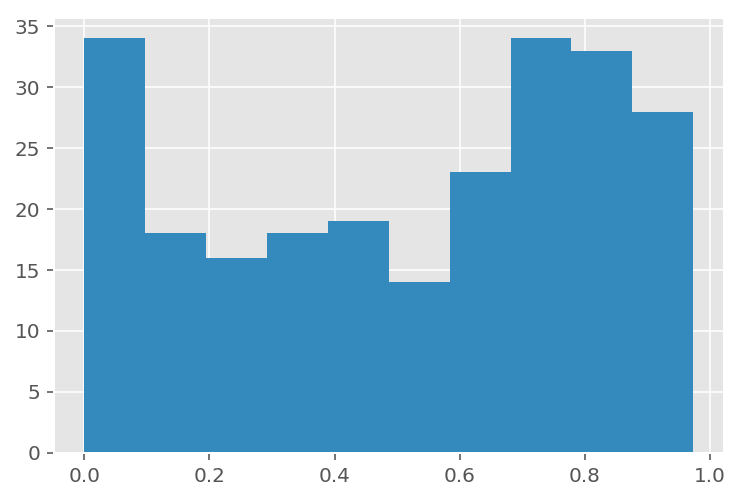

reggae
(10,)


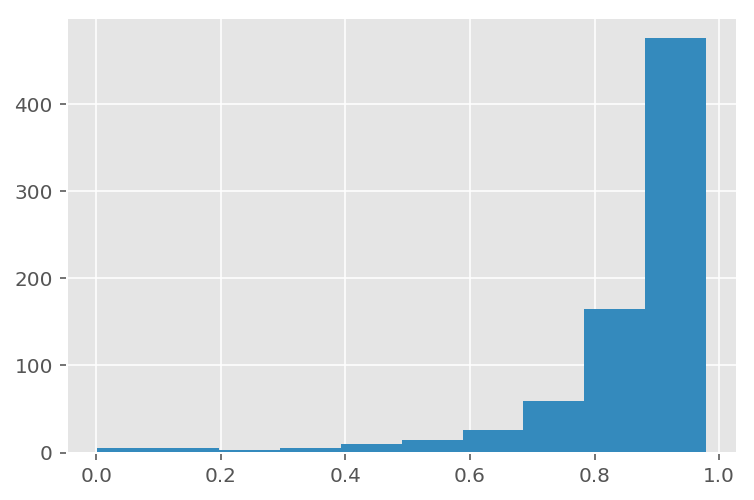

latin
(10,)


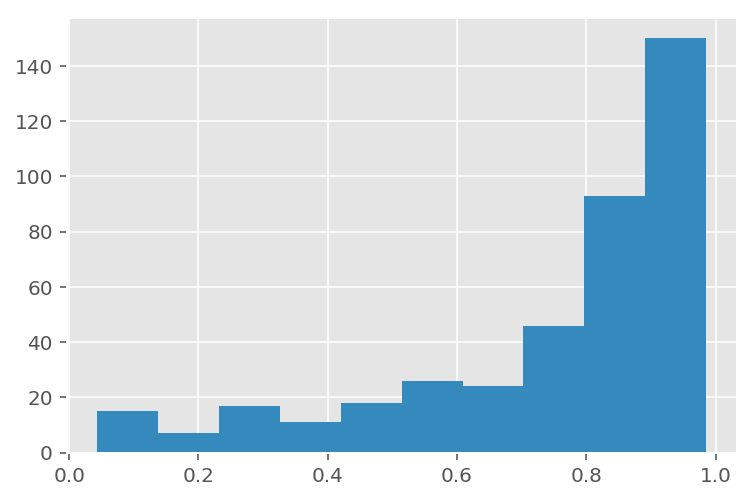

easylistening
(10,)


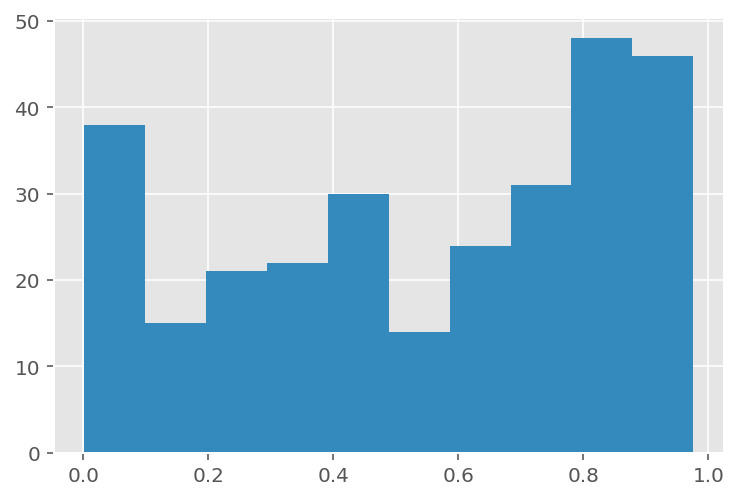

rnb
(10,)


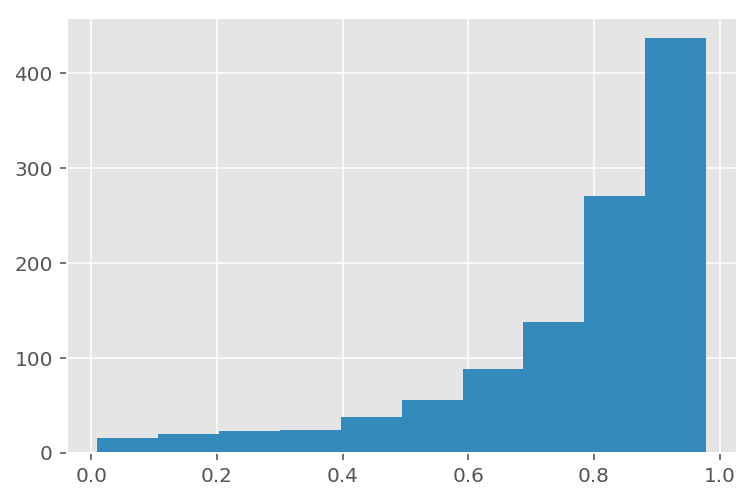

jazz
(10,)


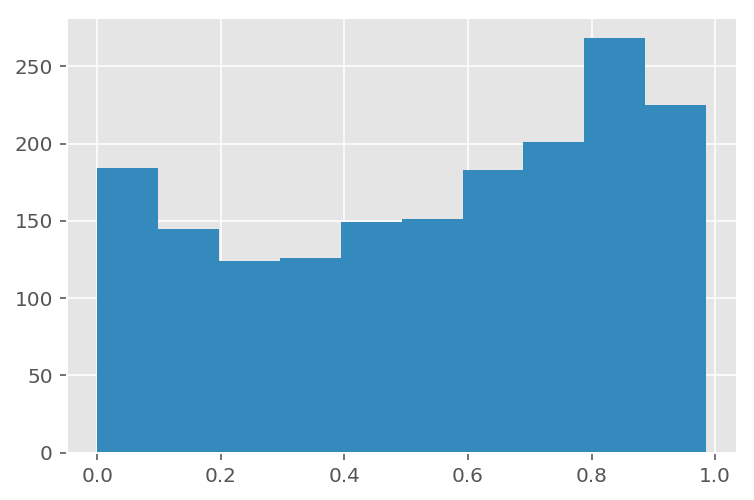

soundtrack
(10,)


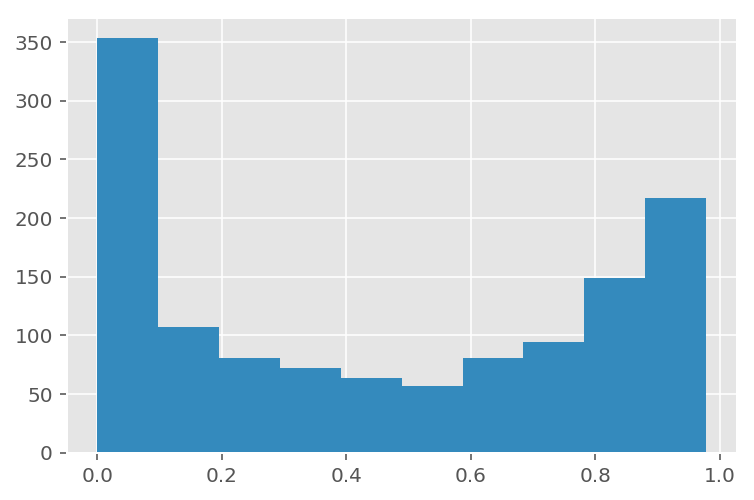

game
(10,)


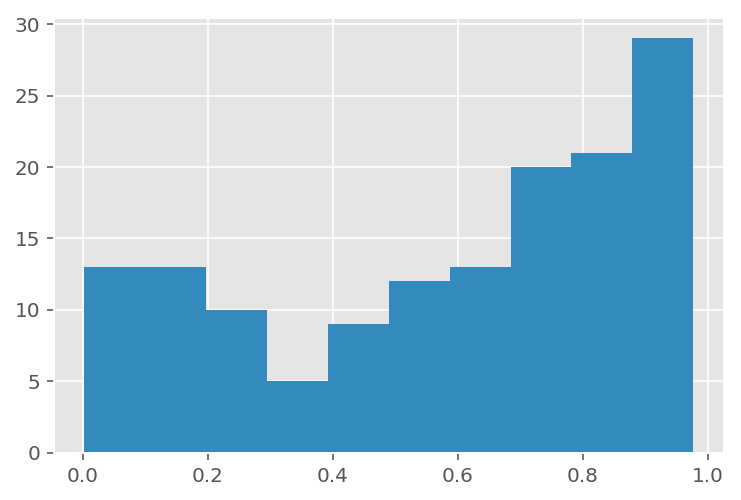

techno
(10,)


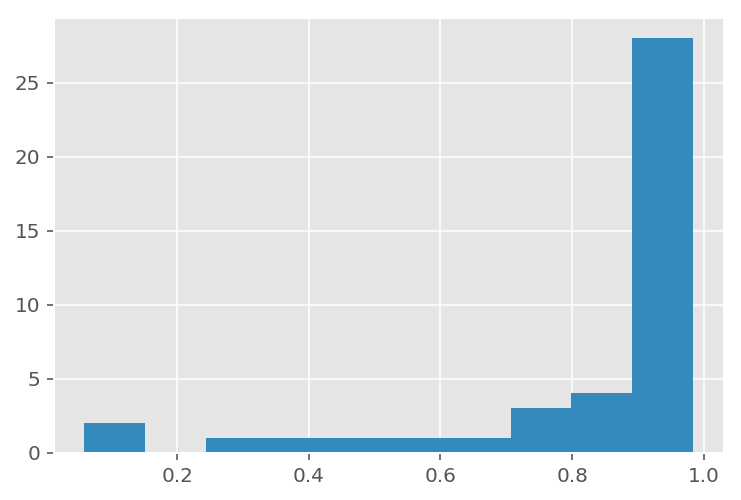

world
(10,)


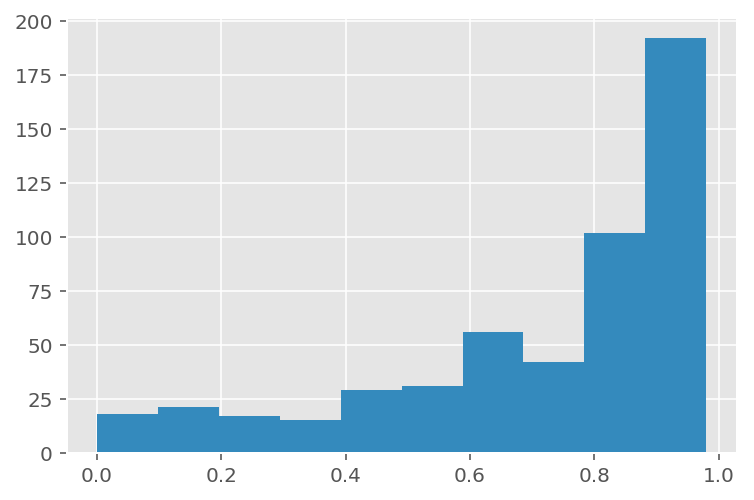

funk
(10,)


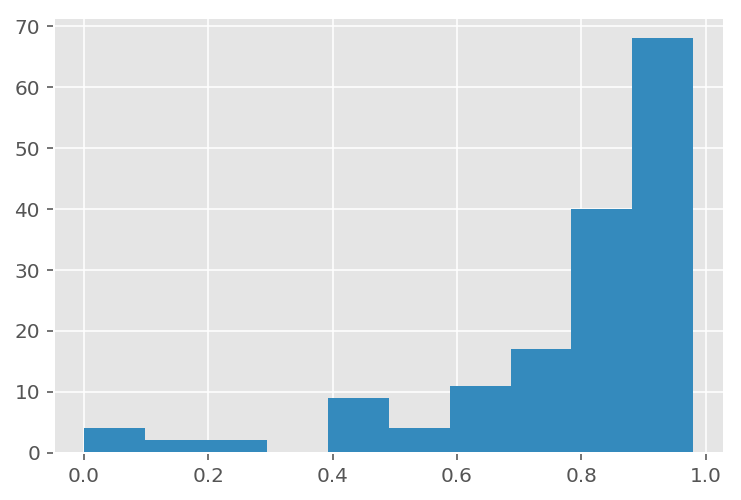

celtic
(10,)


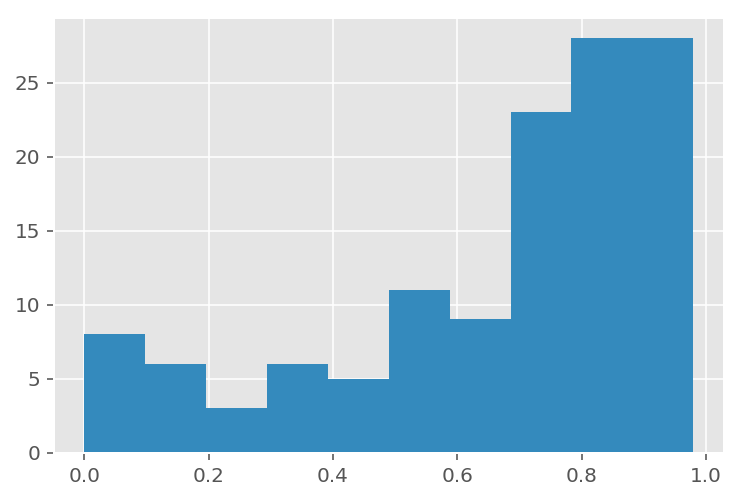

country
(10,)


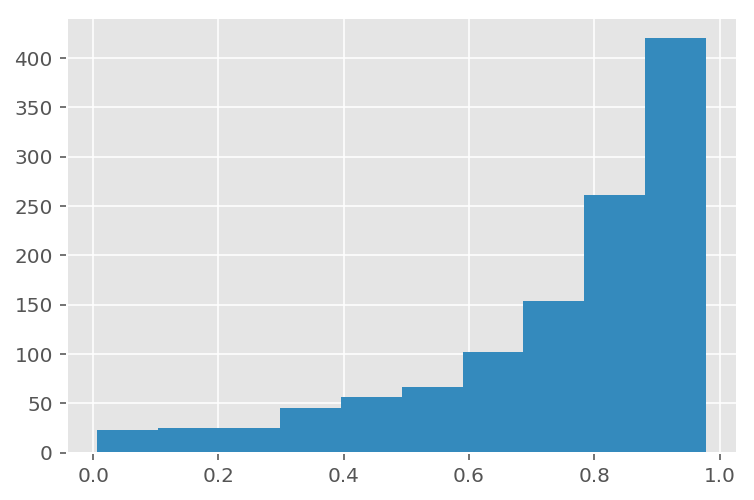

hiphop
(10,)


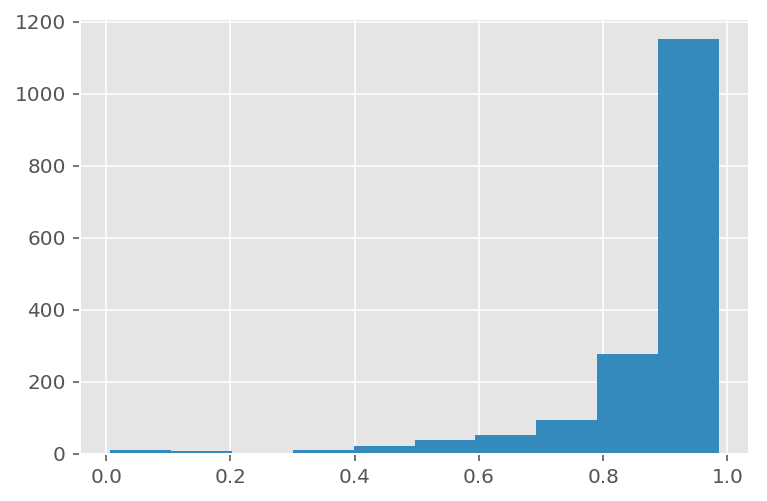

drumnbass
(10,)


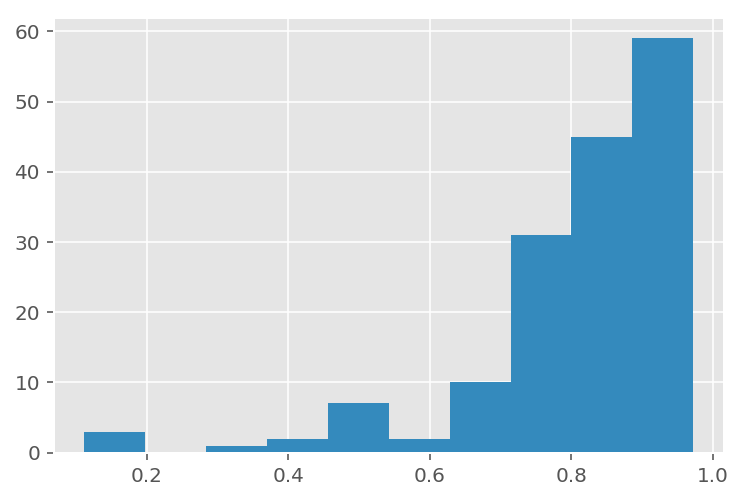

rock/pop
(10,)


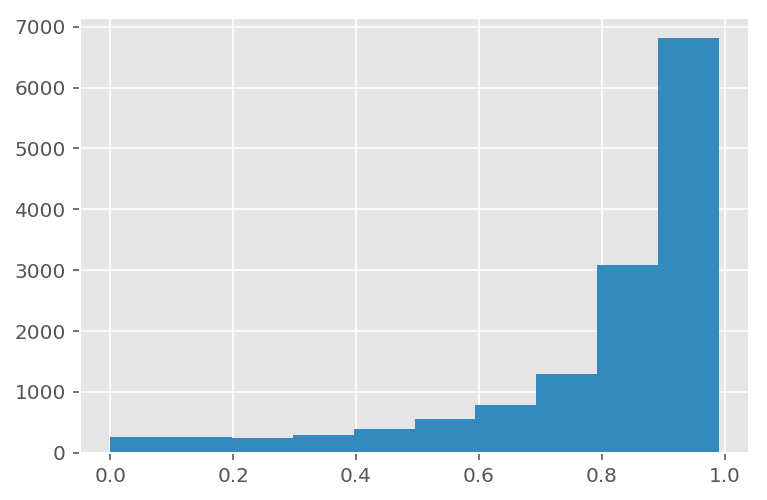

christmas/holiday
(10,)


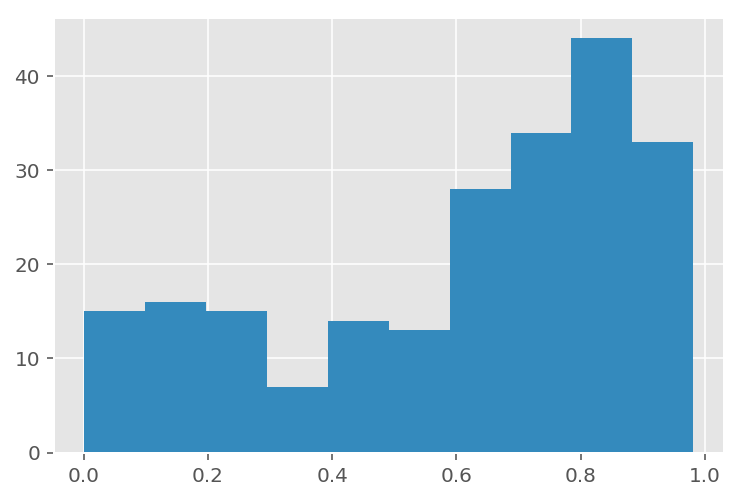

anime
(10,)


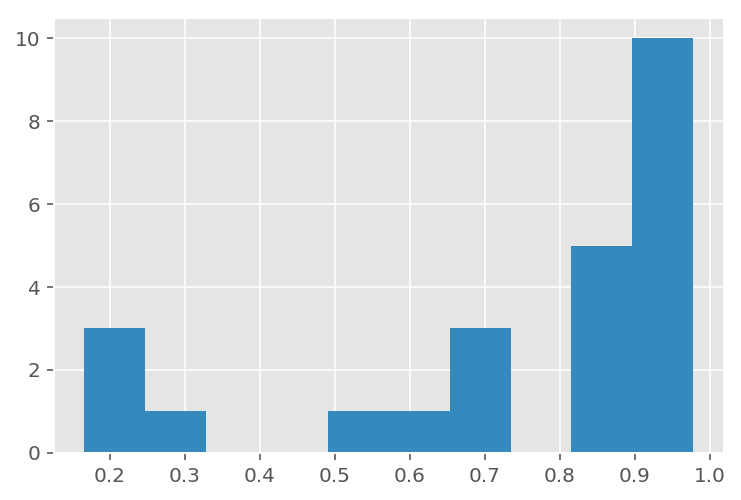

gospel
(10,)


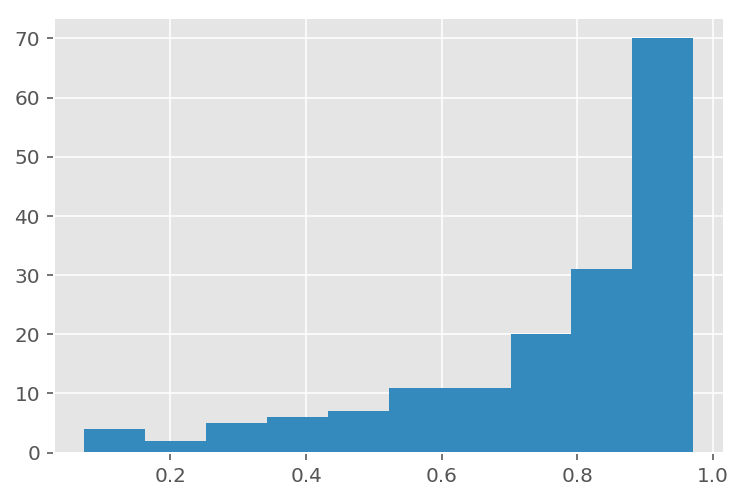

In [203]:
import numpy as np
hist_loudness = np.arange(10)
j=0

for i in myset:    
    groundtruth_genre = groundtruth[groundtruth['genre1'] == i]
    training_data_genre = groundtruth_genre['recordingmbid'].apply(getOnlyUsedFeatures)
    print i
    plt.hist(training_data_genre)
    loud = plt.hist(training_data_genre)
    print np.shape(loud[0])
    hist_loudness = np.vstack((hist_loudness, loud[0]))
    j = j+1
    plt.show()

## Normalize Value in Array

In [221]:
genre_count = np.shape(hist_loudness)[0]

np.amax(hist_loudness[14])

for i in range(genre_count):
    max_value = np.amax(hist_loudness[i])
    array_length = np.shape(hist_loudness)[1]
    for j in range(array_length):
        hist_loudness[i,j] = hist_loudness[i,j]/max_value
        

In [223]:
hist_loudness

array([[ 0.        ,  0.11111111,  0.22222222,  0.33333333,  0.44444444,
         0.55555556,  0.66666667,  0.77777778,  0.88888889,  1.        ],
       [ 0.04511278,  0.04511278,  0.02255639,  0.01503759,  0.05263158,
         0.10526316,  0.07518797,  0.13533835,  0.42857143,  1.        ],
       [ 0.36363636,  0.09090909,  0.09090909,  0.18181818,  0.36363636,
         0.18181818,  0.18181818,  0.45454545,  0.81818182,  1.        ],
       [ 1.        ,  0.40104167,  0.234375  ,  0.18229167,  0.14583333,
         0.11458333,  0.125     ,  0.22916667,  0.15625   ,  0.09895833],
       [ 0.01635769,  0.01090513,  0.01090513,  0.01853871,  0.02399128,
         0.03053435,  0.04580153,  0.13304253,  0.36750273,  1.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.02222222,  0.02222222,  0.06666667,  0.02222222,  0.02222222,
         0.17777778,  0.28888889,  0.37777778

## Calculate Similarity

In [225]:
def histograms_similarity(histogram0, histogram1):
  hs_sim = histogram0.astype(np.float32) - histogram1.astype(np.float32)
  sim = 0
  for i in range(0, hs_sim.size):
    if(hs_sim[i] < 0):
      sim = sim + histogram0[i]
    else:
      sim = sim + histogram1[i]
     
  return sim

In [280]:
# Example.
print '1 vs 2: %.6f' % histograms_similarity(
    hist_loudness[0, :],
    hist_loudness[5, :])

1 vs 2: 0.555556


In [281]:
def compute_self_similarity(feature_vector_matrix, similarity_function = histograms_similarity):
  matsize = np.shape(feature_vector_matrix)[0]
  sim_matrix = np.zeros((matsize, matsize))
  for i in range(0, matsize):
    for j in range(0, matsize):
        sim_matrix[i, j] = similarity_function(feature_vector_matrix[i,:], feature_vector_matrix[j,:])
  return sim_matrix

## Create Similarity Matrix

In [233]:
histograms_self_similarity = compute_self_similarity(
    hist_loudness, histograms_similarity)
print 'HS histograms self-similarity matrix size: %d x %d' % np.shape(histograms_self_similarity)

HS histograms self-similarity matrix size: 32 x 32


In [245]:
np.amax(histograms_self_similarity)

6.9705882352941169

<IPython.core.display.Javascript object>


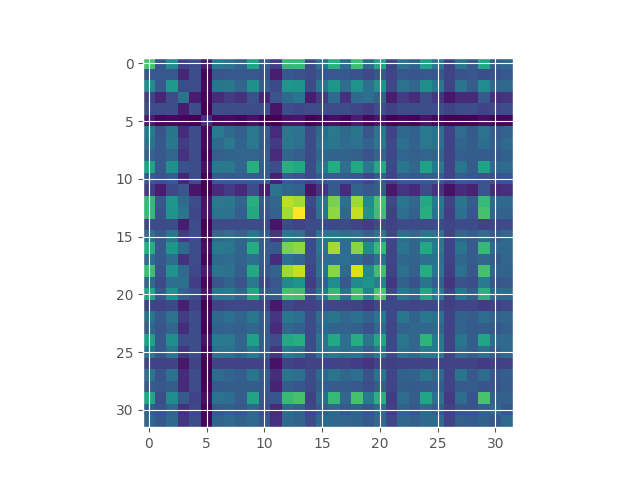

In [232]:
%matplotlib notebook

plt.figure()
plt.imshow(histograms_self_similarity)

## Create Dissimilarity Matrix

In [282]:
def histograms_dissimilarity(histogram0, histogram1):
  hs_dsim = abs(histogram0.astype(np.float32) - histogram1.astype(np.float32))
  dsim = 0
  for i in range(hs_dsim.size):
    dsim = dsim + hs_dsim[i]
     
  return dsim

In [283]:
histograms_dissimilarity(hist_loudness[0, :], hist_loudness[1, :])

3.1654135510325432

In [284]:
# Example.
print '1 vs 2: %.2f' % histograms_dissimilarity(
    hist_loudness[0, :],
    hist_loudness[5, :])

1 vs 2: 4.89


In [285]:
def compute_self_dissimilarity(feature_vector_matrix, dissimilarity_function = histograms_dissimilarity):
  matsize = np.shape(feature_vector_matrix)[0]
  dsim_matrix = np.zeros((matsize, matsize))
  for i in range(0, matsize):
    for j in range(0, matsize):
        dsim_matrix[i, j] = dissimilarity_function(feature_vector_matrix[i,:], feature_vector_matrix[j,:])
  return dsim_matrix

In [286]:
histograms_self_dissimilarity = compute_self_dissimilarity(
    hist_loudness, histograms_dissimilarity)
print 'HS histograms self-dissimilarity matrix size: %d x %d' % np.shape(histograms_self_dissimilarity)

HS histograms self-dissimilarity matrix size: 32 x 32


<IPython.core.display.Javascript object>


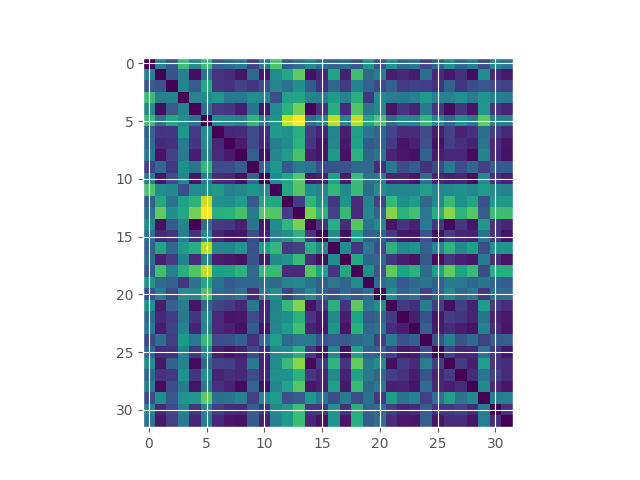

In [287]:
%matplotlib notebook

plt.figure()
plt.imshow(histograms_self_dissimilarity)

In [288]:
myset

{'anime',
 'blues',
 'celtic',
 'childrens',
 'christmas/holiday',
 'classical',
 'comedy',
 'country',
 'dance',
 'drumnbass',
 'dubstep',
 'easylistening',
 'electronic',
 'folk',
 'funk',
 'game',
 'gospel',
 'hiphop',
 'industrial',
 'jazz',
 'latin',
 'newage',
 'reggae',
 'reggaeton',
 'rnb',
 'rock/pop',
 'soundtrack',
 'spoken',
 'techno',
 'trance',
 'world'}

## Train SVM

In [137]:
clf = svm.SVC()
clf.fit(training_data[0:-2], groundtruth['genre1'][0:-2])  

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [140]:

test_features = training_data[-10:]
test_label = groundtruth['genre1'][-10:]
print test_label
print clf.predict(test_features)

486574    soundtrack
486576      rock/pop
486611      rock/pop
486617           rnb
486620       country
486662      rock/pop
486689         dance
486701     classical
486714        hiphop
486716          game
Name: genre1, dtype: object
['rock/pop' 'rock/pop' 'rock/pop' 'rock/pop' 'rock/pop' 'rock/pop'
 'rock/pop' 'rock/pop' 'rock/pop' 'rock/pop']


In [ ]:
 pettyPrintJSON(loadFeatures('1a00a335-fead-46ec-8d4f-06e8341291ea'))